<a id="top"></a>

# Table of Contents

Overview of Step 1 checks on `parsed_data` to guide later cleaning and analysis.

1. [Article Length](#1-article-length)  
   ∘ [1.1 Bar chart of article length](#11-bar-chart-of-article-length)  
   ∘ [1.2 Consistency check: `length` vs. body word count](#12-consistency-check-length-vs-body-word-count)  

2. [Sections Analysis](#2-sections-analysis)

---

<a id="1-article-length"></a>
# 1. Article Length
[↰ Return to Top](#top)



In [19]:
df = pd.read_pickle(DATA_PATH)
print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("\nHead:")
print(df.head(3))

Shape: (43666, 9)
Columns: ['title', 'publisher', 'date', 'section', 'length', 'body', 'correction_appended', 'load_date_at_end', 'source_file']

Head:
                                               title            publisher  \
0                   Fleece of the Century; On Boxing  The New York Times    
1     Ruling Adds to the Risk Of a Monopoly on Power   The New York Times   
2  Gerrymandering and the Rising Risk of a Monopo...  The New York Times    

         date                                     section      length  \
0  2017-08-27                                      SPORTS  1958 words   
1  2019-06-28  Section A; Column 0; National Desk; Pg. 14  1472 words   
2  2019-06-28                                      UPSHOT  1483 words   

                                                body  correction_appended  \
0  \n\nLAS VEGAS — The world finally had the two ...                False   
1  \n\nAt some point or another over the last dec...                False   
2  \n\nAt some 

<a id="11-bar-chart-of-article-length"></a>
### 1.1 Bar chart of article length
[↰ Return to Top](#top)

> **Context.** Visualize how article lengths are distributed to spot the main range and any long tail.

**Inputs:** `length` (string) → parsed to numeric `length_num`.  
**Method:** Bin `length_num` in **400-word** increments; clip at the **99th percentile (~6,100 words)** and group values **≥ 6,100** into a single overflow bin. X-axis labels are sparsified for readability.  
**What to look for:** A right-skewed distribution with a modal band around **800–1.2k words**; see the printed note for the overflow count.


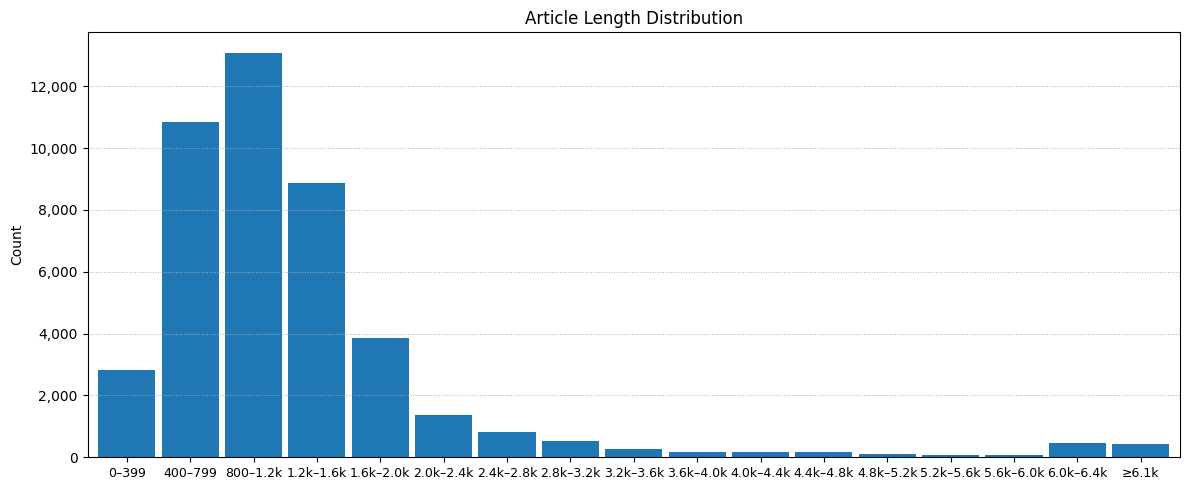

Note: 431 articles in the overflow bin (length ≥ 6,100). Bin size = 400.


In [6]:
# Step 1.1 · Bar chart of article length 
import numpy as np, pandas as pd, matplotlib.pyplot as plt, re
from matplotlib.ticker import FuncFormatter

# reuse df; load if missing
try:
    df
except NameError:
    df = pd.read_pickle("../data/processed/parsed_articles.pkl").copy()

# ensure numeric length
if "length_num" not in df.columns:
    df["length_num"] = pd.to_numeric(
        df["length"].astype(str).str.extract(r"(\d+)")[0], errors="coerce"
    )

x = df["length_num"].dropna().astype(int)
if len(x) == 0:
    print("No numeric lengths to plot.")
else:
    # 1) clip long tail at 99th percentile (round up to nearest 50)
    cap = int(np.ceil(np.percentile(x, 99) / 50.0) * 50)

    # 2) adaptive bin so bars <= 30~35
    bin_size = 50
    while int(np.ceil(cap / bin_size)) > 30:
        bin_size *= 2

    # 3) counts + overflow (>= cap)
    bins = np.arange(0, cap + bin_size, bin_size)
    clipped = x.clip(upper=cap - 1)
    cats = pd.cut(clipped, bins=bins, include_lowest=True, right=True)
    counts = cats.value_counts().sort_index()
    overflow = int((x >= cap).sum())

    # labels helper -> use k-abbrev (e.g., 1.2k)
    def fmt_k(n): 
        return f"{n/1000:.1f}k" if n >= 1000 else f"{n}"
    labels = [f"{fmt_k(l)}–{fmt_k(r-1)}" for l, r in zip(bins[:-1], bins[1:])]
    if overflow > 0:
        counts = pd.concat([counts, pd.Series([overflow], index=[f"≥{fmt_k(cap)}"])])
        labels.append(f"≥{fmt_k(cap)}")

    # 4) draw with sparse ticks
    idx = np.arange(len(counts))
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.bar(idx, counts.values, width=0.9)

    ax.set_title("Article Length Distribution")
    ax.set_ylabel("Count")

    # show ~8–10 x-tick labels max
    n_labels = min(10, len(labels))
    step = max(1, len(labels) // n_labels)
    tick_idx = idx[::step]
    ax.set_xticks(tick_idx)
    ax.set_xticklabels([labels[i] for i in tick_idx], rotation=0, fontsize=9)

    # y as 1,000 separators + light grid
    ax.yaxis.set_major_formatter(FuncFormatter(lambda v, p: f"{int(v):,}"))
    ax.yaxis.grid(True, linestyle=":", linewidth=0.7)
    plt.margins(x=0.01)
    plt.tight_layout()
    plt.show()

    if overflow > 0:
        print(f"Note: {overflow:,} articles in the overflow bin (length ≥ {cap:,}). Bin size = {bin_size}.")

**Findings — 1.1 Article length (bin = 400 words; cap = 6,100; non-null = 43,662/43,666)**   word count = nan - 4
- Distribution is **right-skewed** with a clear mode at **800–1,199 words (30.0%)**.  
- Short pieces are less common (**0–399: 6.5%**); the bulk of articles fall in **400–1,599** (**75.2%**), and **≤1,999** covers **90.5%** of items.  
- Long pieces are rare: only **3.2%** in **2,000–2,399**, and just **~1%** in each bin beyond **3,200** words.  
- **Overflow (≥6,100 words): 431 articles (~1.0%)** grouped into a single bin for readability.  
- Percentages are rounded to 0.1%; cumulative totals may slightly exceed **100%** due to rounding.

**Table highlights (count · % of non-null)**  
- 0–399: **2,821 · 6.5%**  
- 400–799: **10,860 · 24.9%**  
- 800–1,199: **13,092 · 30.0%**  
- 1,200–1,599: **8,862 · 20.3%**  
- 1,600–1,999: **3,857 · 8.8%**  
- ≥6,100: **431 · 1.0%** 



<a id="12-consistency-check-length-vs-body-word-count"></a>
### 1.2 Consistency check: `length` vs. body word count
[↰ Return to Top](#top)

> **Context.** Sanity-check that the provided `length` aligns with the tokenized word count from `body`.

**Inputs:** `length_num` (parsed), `body` → `word_count`.  
**Method:** Compute relative error `|length_num − word_count| / word_count` and report the share within **±5%**.  
**Output:** Match rate + median absolute/relative differences; optionally print a few mismatched examples.


In [11]:
# Step 1.2 · Consistency check exactly as described (±5% + optional examples)
import re, numpy as np, pandas as pd

TOL = 0.05                 # ±5%
SHOW_EXAMPLE_ARTICLES = True

# Reuse df; load if missing
try:
    df
except NameError:
    df = pd.read_pickle("../data/processed/parsed_articles.pkl").copy()

# Inputs: length_num (parsed), body -> word_count
if "length_num" not in df:
    df["length_num"] = pd.to_numeric(df["length"].astype(str).str.extract(r"(\d+)")[0], errors="coerce")

rx = re.compile(r"\b\w+\b", flags=re.UNICODE)
df["word_count"] = df["body"].apply(lambda s: len(rx.findall(s)) if isinstance(s, str) else 0)

# Relative error |length_num - word_count| / word_count
mask = df["length_num"].notna() & (df["word_count"] > 0)
rel_diff = (df.loc[mask, "length_num"] - df.loc[mask, "word_count"]).abs() / df.loc[mask, "word_count"]
abs_diff = (df.loc[mask, "length_num"] - df.loc[mask, "word_count"]).abs()

# Report
print(f"Rows checked: {mask.sum():,}")
print(f"Share within ±5%: {rel_diff.le(TOL).mean():.1%}")
print(f"Median abs diff: {int(abs_diff.median())} words")
print(f"Median rel diff: {rel_diff.median():.1%}")

#print a few mismatched examples
if SHOW_EXAMPLE_ARTICLES:
    examples = (
        df.loc[mask, ["title","section","length","length_num","word_count"]]
          .assign(rel_diff=rel_diff.values)
          .query("rel_diff > @TOL")
          .sort_values("rel_diff", ascending=False)
          .head(5)
    )
    if len(examples):
        with pd.option_context("display.max_colwidth", 120):
            print("\nExamples of mismatches (>±5%):")
            print(examples.to_string(index=False))

Rows checked: 43,658
Share within ±5%: 49.7%
Median abs diff: 51 words
Median rel diff: 5.0%

Examples of mismatches (>±5%):
                                                                      title                                      section    length  length_num  word_count  rel_diff
Best Sellers: Combined Print & E-Book Nonfiction: Sunday, January 01st 2017 Section BR; Column 0; Book Review Desk; Pg.  663 words       663.0          79  7.392405
                   Best Sellers: Audio Nonfiction: Sunday, August 18th 2024       Section BR; Column 0; Book Review Desk 656 words       656.0          79  7.303797
Best Sellers: Combined Print & E-Book Nonfiction: Sunday, January 08th 2017 Section BR; Column 0; Book Review Desk; Pg.  655 words       655.0          79  7.291139
              Best Sellers: Hardcover Nonfiction: Sunday, January 08th 2017 Section BR; Column 0; Book Review Desk; Pg.  638 words       638.0          79  7.075949
             Best Sellers: Hardcover Nonfiction: S

In [14]:
import numpy as np, pandas as pd
rel = (df["length_num"] - df["word_count"]).abs() / df["word_count"].replace(0, np.nan)
top = (rel.gt(0.10)
         .groupby(df["section"])
         .mean()
         .sort_values(ascending=False)
         .head(10))
print((top*100).round(1).astype(str) + "%")


section
Section A; Column 0; National Desk; Pg. 17; IMAGES                                      100.0%
Section 1; Column 1; Foreign Desk; Pg. 16; THE STRUGGLE FOR IRAQ: THE TROOPS            100.0%
Section 6; Column 1; Magazine Desk; Pg. 13                                              100.0%
Section C; Page 13, Column 3; Sports Desk                                               100.0%
Section 1; Column 0; Metropolitan Desk; Pg. 47                                          100.0%
Section MM; Column 0; Magazine Desk; Pg. 45                                             100.0%
Section B; Column 3; Metropolitan Desk; Pg. 1; Crabs Beckon, but Danger Lurks in Mud    100.0%
NEWS; Pg. 6A; Statesline                                                                100.0%
Section B; Column 3; Metropolitan Desk; Pg. 1; Urban, and Looking for the Cowboys       100.0%
Section 11;; Section 11;Page 3;Column 2;Real Estate Desk; Column 2;                     100.0%
dtype: object


Largest outliers are Book Review bestseller listings; the body text likely missed list/table content, so length ≫ word_count.”

<a id="2-sections-analysis"></a>
# 2. Sections Analysis
[↰ Return to Top](#top)

This section will be added later (descriptive analysis only, no prediction), once Step 1 is finalized.


In [17]:
set(df_articles["section"])

{'Section 8;\xa0; Section 8;\xa0 Page 9;\xa0 Column 2;\xa0 Sports Desk\xa0; Column 2;\xa0',
 'ARTS & ENTERTAINMENT; MUSIC PREVIEW; Pg. W-3',
 'NEWS,; SPEAK UP',
 'Section C;\xa0\xa0\xa0; Section C;\xa0\xa0\xa0 Page 15;\xa0\xa0\xa0 Column 1;\xa0\xa0\xa0 Cultural Desk\xa0\xa0\xa0; Column 1;\xa0\xa0\xa0; Review',
 'Section 7;\xa0\xa0; Section 7;\xa0\xa0 Page 38;\xa0\xa0 Column 1;\xa0\xa0 Book Review Desk\xa0\xa0; Column 1;\xa0\xa0; Review',
 "Section C; Column 0; Movies, Performing Arts/Weekend Desk; Pg. 5; MOVIE REVIEW 'TOAST'",
 'Section A; Column 0; Editorial Desk; Pg. 21; MICHELLE GOLDBERG',
 'Section NJ; Column 0; Long Island Weekly Desk; Pg. 8',
 'Section A; Column 1; National Desk; Pg. 21',
 'Section C;\xa0; Section C;\xa0 Page 12;\xa0 Column 1;\xa0 Cultural Desk\xa0; Column 1;\xa0',
 'Section 8;\xa0; Section 8;\xa0Page 10;\xa0Column 4;\xa0Sports Desk\xa0; Column 4;\xa0',
 'SPECIAL-SERIES',
 'Section 14WC;\xa0; Section 14WC;\xa0Page 8;\xa0Column 1;\xa0Westchester Weekly Desk\xa0; C

In [ ]:
#Check for unique section names
from itertools import islice

sections_raw = df_articles["section"].dropna().astype(str)

unique_raw = set(sections_raw)
print("Unique count (raw):", len(unique_raw))
list(islice(unique_raw, 20))  # show 20 samples

In [ ]:
# Clean NBSP and extra spaces
sections_clean = (
    sections_raw
      .str.replace("\xa0", " ", regex=False)
      .str.replace(r"\s+", " ", regex=True)
      .str.strip()
)

unique_clean = set(sections_clean)
print("Unique count (cleaned):", len(unique_clean))
list(islice(unique_clean, 20))  # show 20 samples after cleaning

In [ ]:
import re

# Split on semicolon or slash
parts_series = sections_clean.apply(lambda x: re.split(r"[;/]", x))

# Flatten tokens
tokens = [
    t.strip()
    for parts in parts_series
    for t in parts
    if t and t.strip()
]

print("Total tokens:", len(tokens))
print("Unique tokens:", len(set(tokens)))
list(islice(set(tokens), 20))  # show 20 samples

In [ ]:
from collections import Counter

counts = Counter(tokens)
df_section_token_freq = (
    pd.DataFrame(counts.items(), columns=["Section_Token", "Frequency"])
      .sort_values("Frequency", ascending=False)
      .reset_index(drop=True)
)

# Top 30 tokens
df_section_token_freq.head(50)